In [2]:
import tensorflow_mri as tfmr
import numpy as np
from sklearn.model_selection import train_test_split
from glob import glob
import tensorflow as tf
import tensorflow.keras.backend as K
import random
import matplotlib.pyplot as plt
from skimage import exposure
import scipy
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

2023-07-11 16:43:58.033392: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
import neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback

continue_training = True
model_name = 'AOR-16'

/usr/local/lib/python3.8/dist-packages/neptune/internal/backends/hosted_client.py:50: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
/tmp/ipykernel_227459/1189045373.py:2: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  from neptune.new.integrations.tensorflow_keras import NeptuneCallback


In [4]:
if continue_training:
    run = neptune.init_run(
        project="Aorta/Aorta-raw",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzMjE2ZWMxNi04ZjNkLTRjYjctYWQ1Ni1mY2EyNTU2ZGViYTMifQ==",
        with_id = model_name)  

else:
    run = neptune.init_run(
        project="Aorta/Aorta-raw",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzMjE2ZWMxNi04ZjNkLTRjYjctYWQ1Ni1mY2EyNTU2ZGViYTMifQ==",
    )  # your credentials
    model_name = list(run.__dict__.values())[-6]

/tmp/ipykernel_227459/625125474.py:2: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/Aorta/Aorta-raw/e/AOR-16


In [4]:
patients = [pat.replace('.npy','') for pat in glob('angio_segm/Selected_Aorta/*')] 
train_patients, test_patients = train_test_split(patients, test_size=0.1) #
train_patients, val_patients = train_test_split(train_patients,test_size=0.2)

In [5]:
image_mask = np.load(f"{patients[0]}.npy")
image = image_mask[...,0][...,np.newaxis]
mask = image_mask[...,1][...,np.newaxis]
mask.shape

(160, 100, 80, 1)

In [6]:
class CustomDataGen():    
    def __init__(self, patients,cohort):
        random.shuffle(patients)
        self.patients = patients
        self.cohort = cohort                
    def data_generator(self):
        for patient in self.patients:
            image_mask = np.load(f"{patient}.npy")
            image = image_mask[...,0][...,np.newaxis]
            mask = image_mask[...,1][...,np.newaxis]
            bkg = np.zeros(mask.shape[:2])
            bkg = np.where(np.sum(mask,-1) == 1, 0, 1)
            mask = np.concatenate([bkg[...,np.newaxis],mask], -1)
            image= aug_down_gamma_up(image)
            yield normalize(image), mask.astype('uint8')           
    def get_gen(self):
        return self.data_generator() 	   
def normalize(image):
    mean = np.mean(image)
    std = np.std(image)
    if std != 0:
        norm = (image - mean) / std
    else:
        norm = np.zeros_like(image)
    return norm

def random_gamma(image):#input should be 3d image only
    num_slice = random.randint(0, 3) 
    if num_slice != 0:
        start_slice = random.randint(0, image.shape[0] - 20)
        selected_slices = list(range(start_slice, start_slice + num_slice))
        for i in range(num_slice):
            slice_i = image[selected_slices[i], :, :, 0]
            slice_i = np.clip(slice_i, 0, None)
            gamma=round(np.random.beta(1, 5) * 0.2 + 0.5, 1) #AOR-10 50% gamma=0.55; AOR-11 60% gamma=0.5; AOR-12 gamma=(0.5,0.7) but skewed to 0.5
            ad_slice = exposure.adjust_gamma(slice_i, gamma)
            image[selected_slices[i], :, :, 0] = ad_slice
    return image

def random_dark(image):#input should be 3d image only
    num_slice = random.randint(0, 2) 
    if num_slice != 0:
        start_slice = random.randint(0, image.shape[0] - 20)
        selected_slices = list(range(start_slice, start_slice + num_slice))
        for i in range(num_slice):
            slice_i = image[selected_slices[i], :, :, 0]
            slice_i = np.clip(slice_i, 0, None)
            gamma=round(random.uniform(1.2, 1.7), 1) 
            ad_slice = exposure.adjust_gamma(slice_i, gamma)
            image[selected_slices[i], :, :, 0] = ad_slice
    return image
def aug_down_gamma_up(image):
    adj_image=scipy.ndimage.zoom(image, (1/6,1,1,1), mode='constant')
    gamma_image=random_gamma(adj_image)
    gamma_image=random_dark(adj_image)
    image=scipy.ndimage.zoom(gamma_image, (160/gamma_image.shape[0],1,1,1), mode='constant')
    return image

In [6]:
def iou(y_true, y_pred, dtype=tf.float32):
    # tf tensor casting
    y_pred = tf.convert_to_tensor(y_pred)
    y_pred = tf.cast(y_pred[...,1:], dtype)
    y_true = tf.cast(y_true[...,1:], y_pred.dtype)

    y_pred = tf.squeeze(y_pred)
    y_true = tf.squeeze(y_true)
    
    y_true_pos = tf.reshape(y_true, [-1])
    y_pred_pos = tf.reshape(y_pred, [-1])

    area_intersect = tf.reduce_sum(tf.multiply(y_true_pos, y_pred_pos))
    
    area_true = tf.reduce_sum(y_true_pos)
    area_pred = tf.reduce_sum(y_pred_pos)
    area_union = area_true + area_pred - area_intersect
    
    return tf.math.divide_no_nan(area_intersect, area_union)

def dice_coef(y_true, y_pred, const=K.epsilon()):
    
    # flatten 2-d tensors
    y_true_pos = tf.reshape(y_true[...,1:], [-1])
    y_pred_pos = tf.reshape(y_pred[...,1:], [-1])
    
    # get true pos (TP), false neg (FN), false pos (FP).
    true_pos  = tf.reduce_sum(y_true_pos * y_pred_pos)
    false_neg = tf.reduce_sum(y_true_pos * (1-y_pred_pos))
    false_pos = tf.reduce_sum((1-y_true_pos) * y_pred_pos)
    
    # 2TP/(2TP+FP+FN) == 2TP/()
    coef_val = (2.0 * true_pos + const)/(2.0 * true_pos + false_pos + false_neg)
    
    return coef_val


In [8]:
output_channel=2
batch_size = 1
input_shape = [None,None,None,1]
output_shape = [None,None,None,output_channel] #output channel=2

train_gen = CustomDataGen(train_patients, 'train').get_gen
val_gen   = CustomDataGen(val_patients, 'val').get_gen


output_signature = (tf.TensorSpec(shape=input_shape, dtype=tf.float32), 
                tf.TensorSpec(shape=output_shape, dtype=tf.float32))

train_ds = tf.data.Dataset.from_generator(train_gen, 
                                          output_signature = output_signature)
val_ds = tf.data.Dataset.from_generator(val_gen, 
                                        output_signature = output_signature)

train_ds = train_ds.shuffle(4, seed = 42, reshuffle_each_iteration=True).batch(batch_size).prefetch(-1)
val_ds = val_ds.batch(batch_size).prefetch(-1)

NameError: name 'train_patients' is not defined

In [9]:
X, y = next(iter(train_ds))

2023-07-08 07:42:09.342473: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-07-08 07:42:13.650994: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


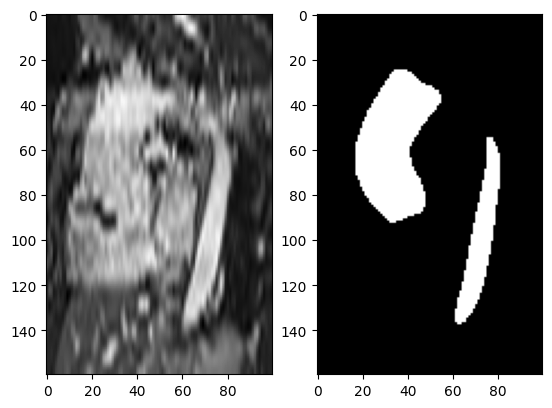

In [10]:
ig, axs = plt.subplots(1,2)

i = 0
axs[0].imshow(X[i,...,33,0],cmap='gray')
axs[1].imshow(y[i,...,33,1],cmap='gray')

In [7]:
if continue_training:
    model = tf.keras.models.load_model(f'models/{model_name}', compile = False)
else:
    inputs = tf.keras.Input(shape = [None,None,None,1]) #define input_shape don't need to specify batch size
    tf.keras.backend.clear_session()
    model = tfmr.models.UNet3D (filters=[64,128,256],
                        kernel_size=3,
                        out_activation='softmax',
                        out_channels = output_channel,
                        use_batch_norm=True)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(), metrics=[dice_coef,iou])


In [18]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='loss', 
                   mode='min', 
                   verbose = 1, 
                   patience = 8)
mc = ModelCheckpoint(f'models/{model_name}',
                  save_best_only= True,
                    monitor='val_loss',
                    mode='min')
neptune_callback = NeptuneCallback(run = run)
model.fit(train_ds,
          validation_data = val_ds, 
          epochs=90,
          callbacks=[es, mc, neptune_callback])
          
run['model'].upload(f'models/{model_name}')

Epoch 1/90


/home/vscode/.local/lib/python3.8/site-packages/neptune_tensorflow_keras/impl/__init__.py:152: NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'NoneType'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type
  self._metric_logger["fit_params"] = self.params
2023-07-07 22:24:39.943398: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-07-07 22:24:44.273599: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-07-07 22:24:45.180709: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


     42/Unknown - 190s 4s/step - loss: 0.0466 - dice_coef: 0.4882 - iou: 0.3319

INFO:tensorflow:Assets written to: models/AOR-16/assets


INFO:tensorflow:Assets written to: models/AOR-16/assets


42/42 [==============================] - 243s 5s/step - loss: 0.0466 - dice_coef: 0.4882 - iou: 0.3319 - val_loss: 0.0919 - val_dice_coef: 0.2699 - val_iou: 0.1582
Epoch 2/90


2023-07-07 22:28:41.188320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-07-07 22:28:45.510479: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


42/42 [==============================] - ETA: 0s - loss: 0.0384 - dice_coef: 0.5205 - iou: 0.3611

INFO:tensorflow:Assets written to: models/AOR-16/assets


INFO:tensorflow:Assets written to: models/AOR-16/assets


42/42 [==============================] - 236s 5s/step - loss: 0.0384 - dice_coef: 0.5205 - iou: 0.3611 - val_loss: 0.0366 - val_dice_coef: 0.5048 - val_iou: 0.3509
Epoch 3/90


2023-07-07 22:32:37.093675: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-07-07 22:32:41.436281: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


42/42 [==============================] - ETA: 0s - loss: 0.0342 - dice_coef: 0.5466 - iou: 0.3868

INFO:tensorflow:Assets written to: models/AOR-16/assets


INFO:tensorflow:Assets written to: models/AOR-16/assets


42/42 [==============================] - 236s 5s/step - loss: 0.0342 - dice_coef: 0.5466 - iou: 0.3868 - val_loss: 0.0319 - val_dice_coef: 0.5488 - val_iou: 0.3921
Epoch 4/90


2023-07-07 22:36:32.705664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-07-07 22:36:37.040270: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


42/42 [==============================] - 231s 5s/step - loss: 0.0307 - dice_coef: 0.5734 - iou: 0.4134 - val_loss: 0.0323 - val_dice_coef: 0.5426 - val_iou: 0.3840
Epoch 5/90


2023-07-07 22:40:23.932644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-07-07 22:40:28.264985: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


42/42 [==============================] - ETA: 0s - loss: 0.0283 - dice_coef: 0.5915 - iou: 0.4317

INFO:tensorflow:Assets written to: models/AOR-16/assets


INFO:tensorflow:Assets written to: models/AOR-16/assets


42/42 [==============================] - 237s 5s/step - loss: 0.0283 - dice_coef: 0.5915 - iou: 0.4317 - val_loss: 0.0276 - val_dice_coef: 0.5780 - val_iou: 0.4193
Epoch 6/90


2023-07-07 22:44:20.526036: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-07-07 22:44:24.848981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


42/42 [==============================] - 231s 5s/step - loss: 0.0266 - dice_coef: 0.6070 - iou: 0.4476 - val_loss: 0.0439 - val_dice_coef: 0.4549 - val_iou: 0.3019
Epoch 7/90


2023-07-07 22:48:11.143648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-07-07 22:48:15.470749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


42/42 [==============================] - ETA: 0s - loss: 0.0254 - dice_coef: 0.6178 - iou: 0.4589

INFO:tensorflow:Assets written to: models/AOR-16/assets


INFO:tensorflow:Assets written to: models/AOR-16/assets


42/42 [==============================] - 236s 5s/step - loss: 0.0254 - dice_coef: 0.6178 - iou: 0.4589 - val_loss: 0.0263 - val_dice_coef: 0.6064 - val_iou: 0.4472
Epoch 8/90


2023-07-07 22:52:06.845420: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-07-07 22:52:11.173454: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


42/42 [==============================] - ETA: 0s - loss: 0.0245 - dice_coef: 0.6288 - iou: 0.4700

INFO:tensorflow:Assets written to: models/AOR-16/assets


INFO:tensorflow:Assets written to: models/AOR-16/assets


42/42 [==============================] - 236s 5s/step - loss: 0.0245 - dice_coef: 0.6288 - iou: 0.4700 - val_loss: 0.0255 - val_dice_coef: 0.5982 - val_iou: 0.4404
Epoch 9/90


2023-07-07 22:56:02.541660: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-07-07 22:56:06.859139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


42/42 [==============================] - ETA: 0s - loss: 0.0221 - dice_coef: 0.6490 - iou: 0.4922

INFO:tensorflow:Assets written to: models/AOR-16/assets


INFO:tensorflow:Assets written to: models/AOR-16/assets


42/42 [==============================] - 236s 5s/step - loss: 0.0221 - dice_coef: 0.6490 - iou: 0.4922 - val_loss: 0.0227 - val_dice_coef: 0.6298 - val_iou: 0.4740
Epoch 10/90


2023-07-07 22:59:58.238710: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-07-07 23:00:02.574677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 4/42 [=>............................] - ETA: 2:44 - loss: 0.0216 - dice_coef: 0.6738 - iou: 0.5177

In [18]:
run['model'].upload(f'models/{model_name}')

In [12]:
for layer in model.layers:
    print(layer.get_config())

{'filters': ListWrapper([64, 64]), 'kernel_size': 3, 'strides': 1, 'activation': 'relu', 'out_activation': 'same', 'use_bias': True, 'kernel_initializer': 'VarianceScaling', 'bias_initializer': 'Zeros', 'kernel_regularizer': None, 'bias_regularizer': None, 'use_batch_norm': True, 'use_sync_bn': False, 'bn_momentum': 0.99, 'bn_epsilon': 0.001, 'use_residual': False, 'use_dropout': False, 'dropout_rate': 0.3, 'dropout_type': 'standard'}
{'filters': ListWrapper([128, 128]), 'kernel_size': 3, 'strides': 1, 'activation': 'relu', 'out_activation': 'same', 'use_bias': True, 'kernel_initializer': 'VarianceScaling', 'bias_initializer': 'Zeros', 'kernel_regularizer': None, 'bias_regularizer': None, 'use_batch_norm': True, 'use_sync_bn': False, 'bn_momentum': 0.99, 'bn_epsilon': 0.001, 'use_residual': False, 'use_dropout': False, 'dropout_rate': 0.3, 'dropout_type': 'standard'}
{'filters': ListWrapper([256, 256]), 'kernel_size': 3, 'strides': 1, 'activation': 'relu', 'out_activation': 'same', 'us

In [13]:
patient = test_patients[3]
X_test = []
y_test = []
test_gen   = CustomDataGen([patient], 'test').get_gen()
for X, y in test_gen:
    X_test.append(X)
    y_test.append(y)
X_test = np.stack(X_test)
y_test = np.stack(y_test)

In [12]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

In [15]:
y_pred = model.predict(X_test)
y_pred = get_one_hot(np.argmax(y_pred,axis = -1), 3)

2023-07-08 07:42:58.828911: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1/1 [==============================] - 5s 5s/step


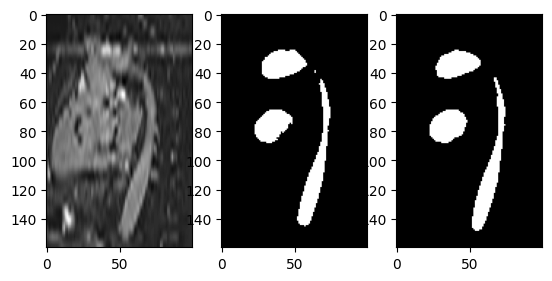

In [16]:
fig, axs = plt.subplots(1,3)

i = 0
axs[0].imshow(X_test[i,...,37,0],cmap='gray')
axs[1].imshow(y_test[i,...,37,1],cmap='gray')
axs[2].imshow(y_pred[i,...,37,1],cmap='gray')

In [13]:
from matplotlib import animation
for patient in test_patients:
    X_test = []
    y_test = []
    test_gen   = CustomDataGen([patient], 'test').get_gen()
    for X, y in test_gen:
        X_test.append(X)
        y_test.append(y)
    X_test = np.stack(X_test)
    y_test = np.stack(y_test)
    y_pred = model.predict(X_test)
    y_pred = get_one_hot(np.argmax(y_pred,axis = -1), 2)

    fig, axs = plt.subplots(1,2, figsize = (7,5))
    frames = []
    for i in range(y_pred.shape[-2]):
        p1 = axs[0].imshow(X_test[0,...,i,0],cmap = 'gray')
        p2 = axs[1].imshow(X_test[0,...,i,0],cmap = 'gray')
        p3 = axs[0].imshow(y_test[0,...,i,-1],alpha=y_test[0,...,i,-1] * 0.7,cmap = 'jet')
        p4 = axs[1].imshow(y_pred[0,...,i,-1],alpha = y_pred[0,...,i,-1] * 0.7,cmap = 'Blues')
        frames.append([p1,p2,p3,p4])
    fig.tight_layout()
    ani = animation.ArtistAnimation(fig, frames)
    ani.save(f'video.gif', fps=y_pred.shape[-2])
    run[f"results/{patient.split('/')[-1]}"].upload('video.gif')
    plt.close()

1/1 [==============================] - 0s 135ms/step


Change Test Set to Barts rescaled-cropped-rescaled data (160,100,80,ImgMask)

In [8]:
patients = [pat.replace('.npy','') for pat in glob('data/ScaleCrop_autoCrop/*')]

In [9]:
class CustomDataGen():    
    def __init__(self, patients,cohort):
        random.shuffle(patients)
        self.patients = patients
        self.cohort = cohort                
    def data_generator(self):
        for patient in self.patients:
            image= np.load(f"{patient}.npy")
            yield normalize(image) #normalising
    
    def get_gen(self):
        return self.data_generator()    
    
def normalize(image):
    mean = np.mean(image)
    std = np.std(image)
    if std != 0:
        norm = (image - mean) / std
    else:
        norm = np.zeros_like(image)
    return norm

In [10]:
patient = patients[8]
X_test = []
test_gen   = CustomDataGen([patient], 'test').get_gen()
for X in test_gen:
    X=X[:,:,:,np.newaxis]
    X_test.append(X)
X_test = np.stack(X_test)

In [11]:
X_test.shape

(1, 160, 100, 80, 1)

In [13]:
y_pred = model.predict(X_test)
y_pred = get_one_hot(np.argmax(y_pred,axis = -1), 3)

2023-07-11 16:45:26.032785: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1/1 [==============================] - 5s 5s/step


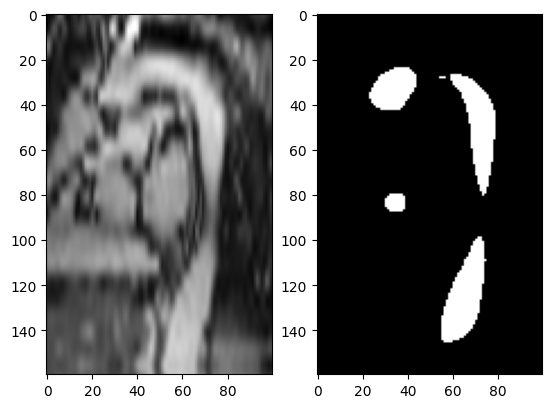

In [14]:
ig, axs = plt.subplots(1,2)

i = 0
axs[0].imshow(X_test[i,...,45,0],cmap='gray')
axs[1].imshow(y_pred[i,...,45,1],cmap='gray')

In [21]:
patient = 'data/ScaleCrop_autoCrop/0117'
X_test = []
test_gen   = CustomDataGen([patient], 'test').get_gen()
for X in test_gen:
    X=X[:,:,:,np.newaxis]
    X_test.append(X)
X_test = np.stack(X_test)
y_pred = model.predict(X_test)
y_pred = get_one_hot(np.argmax(y_pred,axis = -1), 2)
fig, ax = plt.subplots(1,1, figsize = (3, 5)) #single plot but using a subplot to call it
frames = []
for i in range(y_pred.shape[-2]):
    p1 = ax.imshow(X_test[0,...,i,0],cmap = 'gray')
    p2 = ax.imshow(y_pred[0,...,i,1],alpha=y_pred[0,...,i,1] * 0.7,cmap = 'jet')
    frames.append([p1,p2])
fig.tight_layout()
ani = animation.ArtistAnimation(fig, frames)
ani.save(f'video.gif', fps=y_pred.shape[-2])
run[f"BartAutoresults/{patient.split('/')[-1]}"].upload('video.gif')
plt.close()


1/1 [==============================] - 0s 129ms/step


In [29]:
from matplotlib import animation
patient = 'data/ScaleCrop_autoCrop/0379'
X_test = []
test_gen   = CustomDataGen([patient], 'test').get_gen()
for X in test_gen:
    X=X[:,:,:,np.newaxis]
    X_test.append(X)
X_test = np.stack(X_test)
y_pred = model.predict(X_test)
y_pred = get_one_hot(np.argmax(y_pred,axis = -1), 2)
fig, ax = plt.subplots(1,1, figsize = (3, 5)) #single plot but using a subplot to call it
frames = []
for i in range(y_pred.shape[1]):
    p1 = ax.imshow(X_test[0,i,...,0],cmap = 'gray')
    p2 = ax.imshow(y_pred[0,i,...,1],alpha=y_pred[0,i,...,1] * 0.7,cmap = 'jet')
    frames.append([p1,p2])
fig.tight_layout()
ani = animation.ArtistAnimation(fig, frames)
ani.save(f'video.gif', fps=y_pred.shape[1])
run[f"BartsAutoCropTV/{patient.split('/')[-1]}"].upload('video.gif')
plt.close()

1/1 [==============================] - 0s 136ms/step


In [30]:
patients = [pat.replace('.npy','') for pat in glob('data/UKB_autoCrop/*')]

In [31]:
class CustomDataGen():    
    def __init__(self, patients,cohort):
        random.shuffle(patients)
        self.patients = patients
        self.cohort = cohort                
    def data_generator(self):
        for patient in self.patients:
            image= np.load(f"{patient}.npy")
            yield normalize(image) #normalising
    
    def get_gen(self):
        return self.data_generator()    
    
def normalize(image):
    mean = np.mean(image)
    std = np.std(image)
    if std != 0:
        norm = (image - mean) / std
    else:
        norm = np.zeros_like(image)
    return norm

In [32]:
patient = patients[8]
X_test = []
test_gen   = CustomDataGen([patient], 'test').get_gen()
for X in test_gen:
    X=X[:,:,:,np.newaxis]
    X_test.append(X)
X_test = np.stack(X_test)

1/1 [==============================] - 0s 120ms/step


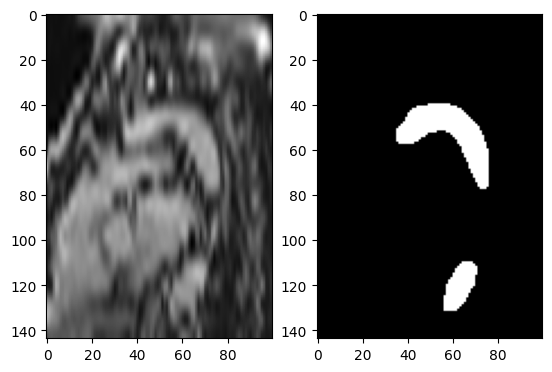

In [33]:
y_pred = model.predict(X_test)
y_pred = get_one_hot(np.argmax(y_pred,axis = -1), 3)
ig, axs = plt.subplots(1,2)

i = 0
axs[0].imshow(X_test[i,...,45,0],cmap='gray')
axs[1].imshow(y_pred[i,...,45,1],cmap='gray')

In [39]:
for patient in patients:  
    X_test = []
    test_gen   = CustomDataGen([patient], 'test').get_gen()
    for X in test_gen:
        X=X[:,:,:,np.newaxis]
        X_test.append(X)
    X_test = np.stack(X_test)
    y_pred = model.predict(X_test)
    y_pred = get_one_hot(np.argmax(y_pred,axis = -1), 2)

    fig, axs = plt.subplots(1,1, figsize = (3,5))
    frames = []
    for i in range(y_pred.shape[-2]):
        p1 = ax.imshow(X_test[0,...,i,0],cmap = 'gray')
        p2 = ax.imshow(y_pred[0,...,i,1],alpha=y_pred[0,...,i,1] * 0.7,cmap = 'jet')
        frames.append([p1,p2])
    fig.tight_layout()
    ani = animation.ArtistAnimation(fig, frames)
    ani.save(f'video.gif', fps=y_pred.shape[-2])
    run[f"UKBautocrop/{patient.split('/')[-1]}"].upload('video.gif')
    plt.close()

1/1 [==============================] - 0s 120ms/step


In [59]:
#from matplotlib import animation
patient = 'data/UKB_autoCrop/1002878'
X_test = []
test_gen   = CustomDataGen([patient], 'test').get_gen()
for X in test_gen:
    X=X[:,:,:,np.newaxis]
    X_test.append(X)
X_test = np.stack(X_test)
y_pred = model.predict(X_test)
y_pred = get_one_hot(np.argmax(y_pred,axis = -1), 2)
fig, ax = plt.subplots(1,1, figsize = (3, 5)) #single plot but using a subplot to call it
frames = []
for i in range(y_pred.shape[-2]):
    p1 = ax.imshow(X_test[0,...,i,0],cmap = 'gray')
    p2 = ax.imshow(y_pred[0,...,i,1],alpha=y_pred[0,...,i,1] * 0.7,cmap = 'jet')
    frames.append([p1,p2])
fig.tight_layout()
ani = animation.ArtistAnimation(fig, frames)
ani.save(f'video.gif', fps=y_pred.shape[-2])
run[f"UKBautocrop/{patient.split('/')[-1]}"].upload('video.gif')
plt.close()

1/1 [==============================] - 0s 116ms/step


Transverse View

In [1]:
from matplotlib import animation
patient = 'data/UKB_autoCrop/1010335'
X_test = []
test_gen   = CustomDataGen([patient], 'test').get_gen()
for X in test_gen:
    X=X[:,:,:,np.newaxis]
    X_test.append(X)
X_test = np.stack(X_test)
y_pred = model.predict(X_test)
y_pred = get_one_hot(np.argmax(y_pred,axis = -1), 2)
fig, ax = plt.subplots(1,1, figsize = (3, 5)) #single plot but using a subplot to call it
frames = []
for i in range(y_pred.shape[1]):
    p1 = ax.imshow(X_test[0,i,...,0],cmap = 'gray')
    p2 = ax.imshow(y_pred[0,i,...,1],alpha=y_pred[0,i,...,1] * 0.7,cmap = 'jet')
    frames.append([p1,p2])
fig.tight_layout()
ani = animation.ArtistAnimation(fig, frames)
ani.save(f'video.gif', fps=y_pred.shape[1])
run[f"UKBautocrop/{patient.split('/')[-1]}"].upload('video.gif')
plt.close()

NameError: name 'CustomDataGen' is not defined